# Introduction to Tensorboard 

This notebook shows how you can use tensorboard, tensorflow's visualization toolkit, to monitor in real-time various intermediate metrics such as loss and accuracy during training and evaluation of the model.

For further details on tensorboard please refer to
https://www.tensorflow.org/tensorboard

In this notebook we will also see how you can use keras callbacks that will be called at various points, such as batch begin and end, and used for monitoring the metrics which can be visualized by tensorboard. All callbacks, except tensorflow.keras.callbacks.Tensorboard can be used without tensorboard. 

For further details on keras callbacks please refer to https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt
# the next instruction makes the plots appear within the notebook
%matplotlib inline

First we want some data.

Our data will be points in the plane. We will generate random points within a square, like so:  

In [4]:
X = 2 * np.random.random((400,2)) - 1

# you can re-run with more or fewer than 200 training data points 

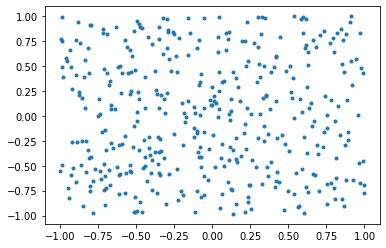

In [5]:
plt.plot(X[:,0],X[:,1],'.')

In [6]:
def classifier(X): # a 3x2 checkerboard pattern
    return (( np.ceil((3/2)*(X[:,0]+1)).astype(int) + np.ceil( X[:,1]+1).astype(int) ) %2).astype(float)

In [7]:
Y = classifier( X ) 

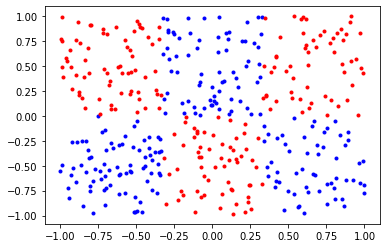

In [8]:
plt.plot(X[Y==0.0,0],X[Y==0.0,1],'b.')
plt.plot(X[Y==1.0,0],X[Y==1.0,1],'r.')

# Building a model

We will build a simple Keras Sequential model.

In [9]:
from tensorflow.keras.models import Sequential

In [10]:
from tensorflow.keras.layers import Dense

In [11]:
model = Sequential() # this creates at keras model object

model.add(Dense(units=24,activation='relu',input_dim=2))
model.add(Dense(units=1,activation='sigmoid'))


In [12]:
model.summary() # prints a summary of the layers you have defined

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile( loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'] )

# Initalize and run tensorboard

In [14]:
# Initialize
%load_ext tensorboard

Tensorboard requires log directories where it can create and maintain event files to log the events specified. If not specified it will create event files in the current directory

We will now create two log directories:
1. To record metrics, both loss and accuracy,  using Tensorboard callback
2. To record metrics, just loss, using a custom callback

In [15]:
import os
import shutil
# Create the root log directory to record metrics using tensorboard callback
logdir = "tensorboard_callback_logs"
if os.path.exists(logdir):
    shutil.rmtree(logdir)
os.mkdir(logdir)

In [17]:
# Run
%tensorboard --logdir tensorboard_callback_logs --port 6006

Reusing TensorBoard on port 6006 (pid 8740), started 0:00:04 ago. (Use '!kill 8740' to kill it.)

In [18]:
# Create root log directory to record metrics using tensorboard callback
logdir = "custom_callback_logs"
if os.path.exists(logdir):
    shutil.rmtree(logdir)
os.mkdir(logdir)

In [20]:
# Run
%tensorboard --logdir custom_callback_logs --port 6007

Reusing TensorBoard on port 6007 (pid 5552), started 0:00:04 ago. (Use '!kill 5552' to kill it.)

# Creating callbacks

In [21]:
import datetime
import tensorflow as tf

# Create tensorboard callbacks 

# Create tensorboard callback that tracks metrics at each epoch
logdir = os.path.join("tensorboard_callback_logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_epoch_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Create tensorboard callback that tracks metrics at each batch
logdir = os.path.join("tensorboard_callback_logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_batch_callback = tf.keras.callbacks.TensorBoard(logdir, update_freq='batch', write_graph=False, profile_batch=0)

In [22]:
import datetime
import tensorflow as tf
# Definew a custom callback to track loss after each batch. The output of this callback should look identical 
# to the output of loss by tensorboard_batch_callback

logdir = os.path.join("custom_callback_logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# Create the event file to record the values
file_writer = tf.summary.create_file_writer(logdir)

# Define a custom callback
class loss_logging_callback(tf.keras.callbacks.Callback):
    epoch = 0
    def on_epoch_end(self, epoch, logs):
        # On each epoch record the epoch number
        self.epoch = (epoch+1) * 10
        
    def on_batch_end(self, batch, logs):
        with file_writer.as_default():
            # NOTE: In order to record scalar values we use the following. For other summaries such as image use 
            # tf.summary.image. For further details refer https://www.tensorflow.org/api_docs/python/tf/summary
            tf.summary.scalar('loss', logs['loss'], step=batch+self.epoch)

In [23]:
# After running the fit method go back to the tensorboard started above and refresh to see the results. 
# You should be able to see metrics, computational graph, histogram of weights and biases in different tabs
# Tensorboard should automatically update every 30 secs
history = model.fit(X, Y,
                    epochs=1000,  # start off with 50 - you may want to increase this to a thousand or more later
                    batch_size=32,  # using a larger batch size (such as 32) is much faster than using batch_size=1
                    validation_split=0.2,
                    # Add callbacjs to the training
                    callbacks=[tensorboard_epoch_callback, tensorboard_batch_callback, loss_logging_callback()]) # this will keep track of validation error: you may want to increase the amount 
                                                      # of validation data to get a more accurate estimate (Our data is synthetic and free)

Train on 320 samples, validate on 80 samples
Epoch 1/1000
320/320 [==============================] - 1s 3ms/sample - loss: 0.6795 - accuracy: 0.5312 - val_loss: 0.6814 - val_accuracy: 0.5125
Epoch 2/1000
320/320 [==============================] - 0s 749us/sample - loss: 0.6735 - accuracy: 0.5188 - val_loss: 0.6779 - val_accuracy: 0.5125
Epoch 3/1000
320/320 [==============================] - 0s 760us/sample - loss: 0.6691 - accuracy: 0.5375 - val_loss: 0.6747 - val_accuracy: 0.5375
Epoch 4/1000
320/320 [==============================] - 0s 851us/sample - loss: 0.6652 - accuracy: 0.5688 - val_loss: 0.6716 - val_accuracy: 0.5500
Epoch 5/1000
320/320 [==============================] - 0s 803us/sample - loss: 0.6612 - accuracy: 0.5938 - val_loss: 0.6686 - val_accuracy: 0.5375
Epoch 6/1000
320/320 [==============================] - 0s 793us/sample - loss: 0.6576 - accuracy: 0.6094 - val_loss: 0.6658 - val_accuracy: 0.5500
Epoch 7/1000
320/320 [==============================] - 0s 728us/samp

320/320 [==============================] - 0s 808us/sample - loss: 0.5733 - accuracy: 0.6781 - val_loss: 0.6036 - val_accuracy: 0.6375
Epoch 55/1000
320/320 [==============================] - 0s 988us/sample - loss: 0.5719 - accuracy: 0.6781 - val_loss: 0.6025 - val_accuracy: 0.6375
Epoch 56/1000
320/320 [==============================] - 0s 968us/sample - loss: 0.5707 - accuracy: 0.6781 - val_loss: 0.6014 - val_accuracy: 0.6500
Epoch 57/1000
320/320 [==============================] - 0s 817us/sample - loss: 0.5697 - accuracy: 0.6781 - val_loss: 0.6004 - val_accuracy: 0.6250
Epoch 58/1000
320/320 [==============================] - 1s 2ms/sample - loss: 0.5681 - accuracy: 0.6812 - val_loss: 0.5992 - val_accuracy: 0.6250
Epoch 59/1000
320/320 [==============================] - 0s 802us/sample - loss: 0.5669 - accuracy: 0.6781 - val_loss: 0.5983 - val_accuracy: 0.6250
Epoch 60/1000
320/320 [==============================] - 0s 836us/sample - loss: 0.5656 - accuracy: 0.6844 - val_loss: 0.5

Epoch 108/1000
192/320 [=================>............] - ETA: 0s - loss: 0.5005 - accuracy: 0.7708

KeyboardInterrupt: 

In [ ]:
def plot_nn_predictions( kerasmodel ):
    x_values = np.linspace(-1,1,200)
    y_values = np.linspace(-1,1,200)
    
# challenge: this function is rather slow because the Keras model is being used to make one prediction at a time. 
# This incurs quite a large overhead: it is more efficient to make many predictions at once. Can you modify this 
# function to do this? 

    J_grid = np.zeros([x_values.size,y_values.size])
    
    x_indices = []
    y_indices = []
    
    input_array = np.zeros( [x_values.size * y_values.size, 2] )
    
    row = 0 
    for x_index in range(0, x_values.size):
        for y_index in range(0, y_values.size):
            x_indices.append(x_index)
            y_indices.append(y_index)
            input_array[row,:] = np.array([x_values[x_index], y_values[y_index]])
            row += 1
    
    predicted_y = kerasmodel.predict(input_array)
    
    row = 0 
    for x_index in range(0, x_values.size):
        for y_index in range(0, y_values.size):
            J_grid[x_index,y_index] = predicted_y[row]
            row += 1
    
    plt.imshow(J_grid.transpose(), origin='lower',extent=[-1,1,-1,1])
    plt.colorbar() 

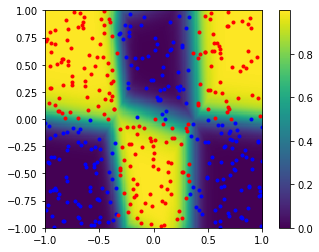

In [25]:
plot_nn_predictions(model)

plt.plot(X[Y==0.0,0],X[Y==0.0,1],'b.')
plt.plot(X[Y==1.0,0],X[Y==1.0,1],'r.')